In [1]:
import os
import sys
import gc
import itertools

import torch
import scanpy as sc
import pandas as pd
import seaborn as sns
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
import umap
from tqdm import tqdm
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
import torch.nn.functional as F
import anndata as ad
from scipy.sparse import csc_matrix
# expression_only1.data
# expression_only1.data.concatenate(expression_only2.data)
# expression=[expression_only1.data,expression_only2.data]
import scanpy as sc
# from context import unifan 
sys.path.append(r"../")
from unifan.datasets1 import AnnDataset, ContrDataset

from unifan.annoclusterV4 import AnnoCluster
from unifan.autoencoderV2 import autoencoder
from unifan.KLCLRv4 import KLCLR
from unifan.classifier import classifier
from unifan.utils import getGeneSetMatrix
from unifan.trainer import Trainer
from src.config_label import Config

/home/lcy/anaconda3/envs/unifan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

config = Config()

In [3]:
adata = ad.concat([config.adata1, config.adata2])

In [4]:
adata.obs['Manuscript_Identity'].astype('category')

CellBarcode_Identity
001C_AAAGTAGCAATGACCT       Basal
001C_AACCGCGGTTATGTGC       Basal
001C_ACACCCTCATTGTGCA        ATII
001C_ACAGCCGGTGTTGGGA         ATI
001C_ACCGTAATCACTTCAT       Basal
                           ...   
59I_TGGCCAGTCGTACGGC        Basal
59I_TGTATTCTCAGTCAGT     Ciliated
59I_TGTGTTTTCAGGATCT     Ciliated
59I_TTCCCAGTCCTGCCAT         ATII
59I_TTGACTTTCCAGATCA     Ciliated
Name: Manuscript_Identity, Length: 18030, dtype: category
Categories (10, object): ['ATI', 'ATII', 'Aberrant_Basaloid', 'Basal', ..., 'Goblet', 'Ionocyte', 'Mesothelial', 'PNEC']

In [5]:
clusters_true_project1 = config.adata1.obs['Manuscript_Identity']
sex_mapping = {}
k = 0
for i in np.unique(clusters_true_project1):
    sex_mapping[i] = k
    k = k + 1
clusters_true1 = clusters_true_project1
print(clusters_true1)

clusters_true_project2 = config.adata2.obs['Manuscript_Identity']
sex_mapping = {}
k = 0
for i in np.unique(clusters_true_project2):
    sex_mapping[i] = k
    k = k + 1
clusters_true2 = clusters_true_project2
print(clusters_true2)

clusters_true_project = adata.obs['Manuscript_Identity'].astype('category')
sex_mapping = {}
k = 0
for i in np.unique(clusters_true_project):
    sex_mapping[i] = k
    k = k + 1
clusters_true = clusters_true_project
print(clusters_true)


CellBarcode_Identity
001C_AAAGTAGCAATGACCT          Basal
001C_AACCGCGGTTATGTGC          Basal
001C_ACACCCTCATTGTGCA           ATII
001C_ACAGCCGGTGTTGGGA            ATI
001C_ACCGTAATCACTTCAT          Basal
                            ...     
484C_CTGTTTAGTCACCCAG    Mesothelial
484C_GAGTCCGGTAAGGGCT           Club
484C_GGACAAGCAAGCGCTC       Ciliated
484C_GTTACAGCATGTAAGA          Basal
484C_TCAATCTAGGTGATAT           ATII
Name: Manuscript_Identity, Length: 4807, dtype: category
Categories (9, object): ['ATI', 'ATII', 'Basal', 'Ciliated', ..., 'Goblet', 'Ionocyte', 'Mesothelial', 'PNEC']
CellBarcode_Identity
010I_AAACCTGAGCTTTGGT    Ciliated
010I_AAACCTGAGTTGAGTA    Ciliated
010I_AAACCTGCATGGTAGG        Club
010I_AAACCTGGTAGGACAC      Goblet
010I_AAAGATGGTCATGCAT        Club
                           ...   
59I_TGGCCAGTCGTACGGC        Basal
59I_TGTATTCTCAGTCAGT     Ciliated
59I_TGTGTTTTCAGGATCT     Ciliated
59I_TTCCCAGTCCTGCCAT         ATII
59I_TTGACTTTCCAGATCA     Ciliated
Name: Man

In [6]:

model_autoencoder = autoencoder(input_dim=config.G, z_dim=config.z_dim, 
                                encoder_dim=config.z_encoder_dim, emission_dim=config.z_decoder_dim,
                                num_layers_encoder=config.z_encoder_layers, num_layers_decoder=config.z_decoder_layers,
                                reconstruction_network='gaussian', decoding_network='gaussian',
                                use_cuda=config.use_cuda)

In [7]:
trainer = Trainer(dataset = config.expression_integrated, model=model_autoencoder,learning_rate=0.001, model_name="pretrain_z_ZINB", batch_size=1024,
                            num_epochs=config.pretrain_epoch, save_infer=True, output_folder=config.pretrain_z_folder, num_workers=0,
                            use_cuda=config.use_cuda)
trainer.train()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.42it/s]



loss = 0.3298378341338214
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.26409995643531575
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.23679784115623026
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]



loss = 0.2248972400146372
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]



loss = 0.22130152758430033
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.21910826335935032
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.21743968830389135
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]



loss = 0.2164197450175005
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51it/s]



loss = 0.21599175474222967
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.47it/s]



loss = 0.21556847761659062
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.2154463398105958
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.55it/s]



loss = 0.21491504416746252
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]



loss = 0.21475022417657516
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.2144870004233192
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.47it/s]



loss = 0.21439072752700133
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.53it/s]



loss = 0.21401207499644337
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]



loss = 0.2135885454276029
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51it/s]



loss = 0.2135313398697797
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]



loss = 0.21315580080537236
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]



loss = 0.21296823375365315
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.21289843671462116
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.62it/s]



loss = 0.21271981211269603
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]



loss = 0.21237925922169404
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.21180382370948792
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]



loss = 0.21187546498635235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.51it/s]



loss = 0.2117937899687711
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.2116114567307865
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.53it/s]



loss = 0.21133849988965428
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:10<00:00,  1.65it/s]



loss = 0.21112784217385686
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.60it/s]



loss = 0.21113982095437892


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.49it/s]



loss = 0.21089057273724499
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.47it/s]



loss = 0.210630781510297
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.52it/s]



loss = 0.2106257948805304
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.21052745861165664
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.21021388208164887
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.54it/s]



loss = 0.2101363942903631
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.56it/s]



loss = 0.21017458596650293


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]



loss = 0.2100272783461739
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.59it/s]



loss = 0.20998255031950333
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.50it/s]



loss = 0.2097715016673593
save optimal model



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:08<00:00,  2.18it/s]


In [6]:
z_init = np.load(config.input_z_ZINB_path)
try:
    z_init = z_init.numpy()
except AttributeError:
    pass
z_init1 = z_init[:config.N_project1]
z_init2 = z_init[config.N_project1:]

In [7]:
z_dim = 128
random_seed=22
# initialize using leiden clustering
adata = sc.AnnData(X=z_init)
adata.obsm['X_unifan'] = z_init

# Compute the neighborhood graph and embed it using UMAP
sc.pp.neighbors(adata, n_pcs=z_dim,  use_rep='X_unifan', random_state=random_seed)
sc.tl.umap(adata)

# Cluster cells using the Louvain algorithm
sc.tl.louvain(adata, resolution=1.0)

# Refine clustering with the Leiden algorithm
sc.external.tl.leiden(adata, resolution=1.0)

ImportError: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /home/lcy/anaconda3/envs/unifan/lib/python3.9/site-packages/louvain/_c_louvain.cpython-39-x86_64-linux-gnu.so)

In [13]:
z_dim = 128
random_seed=22
# initialize using leiden clustering
adata = sc.AnnData(X=z_init)
adata.obsm['X_unifan'] = z_init
sc.pp.neighbors(adata, n_pcs=z_dim,  use_rep='X_unifan', random_state=random_seed)



best_ari = 0
best_resolution = 0
for resolution in range (1,100):
    resolution = resolution / 100
    sc.tl.leiden(adata, resolution=resolution, random_state=random_seed)
    clusters_pre1 = adata.obs['leiden'].astype('int').values
    ari_smaller = adjusted_rand_score(clusters_true,
                                      clusters_pre)
    if ari_smaller>best_ari:
        best_ari = ari_smaller
        best_resolution = resolution


sc.tl.leiden(adata, resolution=best_resolution, random_state=random_seed)
clusters_pre = adata.obs['leiden'].astype('int').values  # original as string



# initialize centroids
try:
    df_cluster = pd.DataFrame(z_init.detach().cpu().numpy())
except AttributeError:
    df_cluster = pd.DataFrame(z_init)

cluster_labels = np.unique(clusters_pre)
M = len(set(cluster_labels))  # set as number of clusters
df_cluster['cluster'] = clusters_pre

# get centroids
centroids = df_cluster.groupby('cluster').mean().values
centroids_torch_project = torch.from_numpy(centroids)
print(centroids_torch_project.shape)

torch.Size([2, 128])


Z: ARI for smaller cluster: 0.555418465234781
Z: NMI for smaller cluster: 0.5751114994208716
Z: silhouette for smaller cluster: 0.2341688573360443


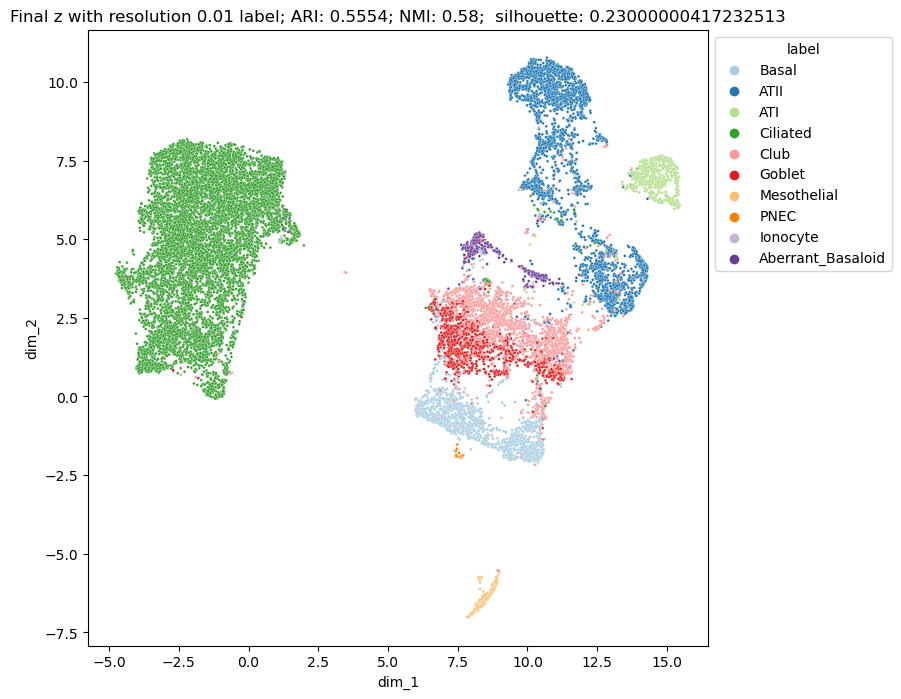

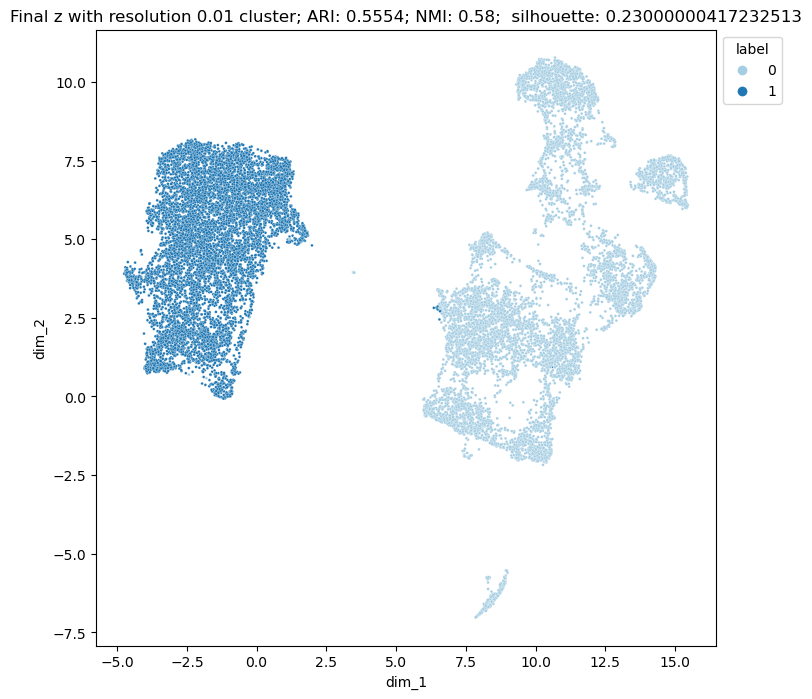

In [14]:

if clusters_true is not None:

    ari_smaller = adjusted_rand_score(clusters_true,
                                      clusters_pre)
    nmi_smaller = adjusted_mutual_info_score(clusters_true, clusters_pre)
    silhouette = silhouette_score(z_init, clusters_pre)
    print(f"Z: ARI for smaller cluster: {ari_smaller}")
    print(f"Z: NMI for smaller cluster: {nmi_smaller}")
    print(f"Z: silhouette for smaller cluster: {silhouette}")
else:
    ari_smaller = np.nan
    nmi_smaller = np.nan

umap_original = umap.UMAP(metric='correlation').fit_transform(z_init)

# color by cluster
hues = {'label': clusters_true_project.tolist(), 'cluster': clusters_pre}
for k, v in hues.items():
    df_plot = pd.DataFrame(umap_original)
    if v is None:
        df_plot['label'] = np.repeat("Label not available", df_plot.shape[0])
    else:
        df_plot['label'] = v
    df_plot['label'].astype('str')
    df_plot.columns = ['dim_1', 'dim_2', 'label']

    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(x='dim_1', y='dim_2', hue='label', data=df_plot, palette="Paired",
                    legend=True, s=4)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.title(f"Final z with resolution {best_resolution} {k}; ARI: {round(ari_smaller, 4)}; NMI: {round(nmi_smaller, 2)};  silhouette: {round(silhouette, 2)}")
#     plt.savefig(os.path.join(pretrain_z_folder, f"z_{z_epoch}_{k}.png"), bbox_inches="tight", format="png")
    #plt.savefig(k+'ipf_control_scICA.pdf',bbox_inches = 'tight')
    plt.show()
    
    plt.close()